Helpers to load `APT_coherence_T` pickles into Python using the installed `rqc` package.

In [84]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path

# Prefer the installed rqc package, not the local repo copy in control_transition
SITE_PACKAGES = '/p/home/hpan/.pyenv/versions/miniforge3-25.1.1-2/lib/python3.12/site-packages'
PROJECT_ROOT = os.path.expandvars('$WORKDIR/control_transition')
LOCAL_RQC = str(Path(PROJECT_ROOT) / 'rqc')

clean_sys_path = []
for p in sys.path:
    if p in ('', os.getcwd(), PROJECT_ROOT, LOCAL_RQC):
        continue
    if 'control_transition' in p and 'site-packages' not in p:
        continue
    clean_sys_path.append(p)
if SITE_PACKAGES not in clean_sys_path:
    clean_sys_path.insert(0, SITE_PACKAGES)
sys.path = clean_sys_path

if 'rqc' in sys.modules:
    del sys.modules['rqc']
importlib.invalidate_caches()
import rqc

DATA_DIR = os.path.expandvars('$WORKDIR/control_transition/APT_coherence_T')
# ZIP_PATH = os.path.expandvars('$WORKDIR/control_transition/APT_coherence_T.zip')
ZIP_PATH = os.path.expandvars('$WORKDIR/control_transition/APT_coherence_T_pf1.zip')

P_M_VALUES = np.hstack([np.arange(0, 0.08, 0.01), np.arange(0.08, 0.101, 0.005),np.arange(0.11, 0.2, 0.01)])
BATCH_CONFIG = {
    12: {'es_batch': 2000, 'num_batches': 1},
    14: {'es_batch': 2000, 'num_batches': 1},
    16: {'es_batch': 2000, 'num_batches': 1},
    18: {'es_batch': 2000, 'num_batches': 1},
    20: {'es_batch': 2000, 'num_batches': 1},
    22: {'es_batch': 1000, 'num_batches': 2},
    24: {'es_batch': 100, 'num_batches': 20},
}

FN_TEMPLATE = (
    # Old template (before batch config change):
    # 'APT_En({es_range[0]},{es_range[1]})_EnC({es_C_start},{es_C_end})_pm({p_m:.3f},{p_m:.3f},1)_pf(0.000,0.000,{p_f})_L{L}_coherence_T.pickle'
    # Current template matches actual files: En part is fixed (1,2), EnC part varies by batch
    # 'APT_En(1,2)_EnC({es_C_range[0]},{es_C_range[1]})_pm({p_m:.3f},{p_m:.3f},1)_pf(0.000,0.000,{p_f})_L{L}_coherence_T.pickle'
    'APT_En(1,2)_EnC({es_C_range[0]},{es_C_range[1]})_pm({p_m:.3f},{p_m:.3f},1)_pf(1.000,1.000,{p_f})_L{L}_coherence_T.pickle'
)

In [85]:
def _load_pickle_with_swap(fn):
    data = rqc.load_pickle(fn)
    coherence = data.get('coherence')
    if coherence is not None and getattr(coherence, 'ndim', 0) == 5:
        # stored as (p_m, p_f, es_m, es_C, T); swap axes to match parse_APT_T expectation
        data['coherence'] = np.swapaxes(coherence, 2, 3)
    return data


def _load_zip_pickle_with_swap(fn, z):
    data = rqc.load_zip_pickle(fn, z)
    coherence = data.get('coherence')
    if coherence is not None and getattr(coherence, 'ndim', 0) == 5:
        data['coherence'] = np.swapaxes(coherence, 2, 3)
    return data


def load_apt_coherence(use_zip=True, L_list=(12, 14, 16, 18, 20, 22, 24)):
    """Load APT coherence pickles into a parsed dictionary using rqc.generate_params."""
    load_data = _load_zip_pickle_with_swap if use_zip else _load_pickle_with_swap
    data_dict = {'fn': set()}

    for L in L_list:
        cfg = BATCH_CONFIG[L]
        es_ranges = []
        for batch_idx in range(cfg['num_batches']):
            es_start = 1 + batch_idx * cfg['es_batch']
            es_end = min(1 + (batch_idx + 1) * cfg['es_batch'], 2001)
            es_ranges.append((es_start, es_end))

        data_dict = rqc.generate_params(
            # fixed_params={'es_start': 1, 'es_end': 2, 'p_f': -1, 'L': L},
            fixed_params={'es_start': 1, 'es_end': 2, 'p_f': 1, 'L': L},
            vary_params={'p_m': P_M_VALUES, 'es_C_range': es_ranges},
            fn_template=FN_TEMPLATE,
            fn_dir_template=DATA_DIR,
            input_params_template='',
            load_data=load_data,
            filename=None,
            filelist=None,
            load=True,
            data_dict=data_dict,
            zip_fn=ZIP_PATH if use_zip else None,
        )

    return data_dict


def apt_coherence_to_df(data_dict):
    """Convert the loaded coherence dictionary to a pandas DataFrame."""
    return rqc.convert_pd(data_dict, names=['Metrics', 'L', 'p_m', 'p_f', 'es_C', 'es_m'])

# Example:
# data_dict = load_apt_coherence()
# df = apt_coherence_to_df(data_dict)

In [65]:
data_dict = load_apt_coherence()

generate_params:   0%|          | 0/22 [00:00<?, ?it/s]

generate_params: 100%|██████████| 440/440 [00:00<00:00, 380985.50it/s]


In [66]:
data_df = apt_coherence_to_df(data_dict)

In [67]:
data_df

observations
Metrics   L  p_m  p_f es_C es_m                                                   
coherence 12 0.00 1.0 1    1     [906.8074456317959, 2157.4563822796254, 2711.4...
                      2    1     [825.0045057915493, 2289.80864141572, 2909.322...
                      3    1     [916.1432764541145, 2398.846072339343, 2780.80...
                      4    1     [1126.0416346148775, 2177.636681437099, 2793.8...
                      5    1     [1392.2096317665423, 2376.3273486885923, 3000....
...                                                                            ...
          22 0.18 1.0 1996 1     [8444.090679478313, 50965.29874871835, 14608.2...
                      1997 1     [2080.324854754684, 956.8424426121107, 811.464...
                      1998 1     [37578.84839887325, 62066.637294090906, 30935....
                      1999 1     [39166.09704852304, 39847.24298298122, 21816.6...
                      2000 1     [1493.7311336326923, 14498.12381851433, 82858....

[192000 rows x 1 columns]

# p_m = p_f 

In [ ]:
data_df

observations
Metrics   L  p_m  p_f es_C es_m                                                   
coherence 12 0.00 0.0 1    1     [906.8074456317959, 2157.4563822796254, 2711.4...
                      2    1     [825.0045057915493, 2289.80864141572, 2909.322...
                      3    1     [916.1432764541145, 2398.846072339343, 2780.80...
                      4    1     [1126.0416346148775, 2177.636681437099, 2793.8...
                      5    1     [1392.2096317665423, 2376.3273486885923, 3000....
...                                                                            ...
          24 0.19 0.0 1996 1     [5146.148525462436, 377288.7240916595, 188371....
                      1997 1     [7432.907420172494, 53423.45497293726, 6273.82...
                      1998 1     [23472.613738804845, 277310.10015821835, 16315...
                      1999 1     [74687.39406702659, 29214.905328052577, 15112....
                      2000 1     [52092.906007654914, 4305.196484429954, 32751....

[308000 rows x 1 columns]

In [6]:
data_df.xs(0.1, level='p_m')

observations
Metrics   L  p_f es_C es_m                                                   
coherence 12 0.0 1    1     [219.08863214727953, 404.37041801012435, 872.0...
                 2    1     [498.1623477154881, 1022.7484813059763, 2097.0...
                 3    1     [789.0438211568121, 1444.4405279890907, 691.84...
                 4    1     [539.3123955454417, 846.5853047720809, 573.195...
                 5    1     [156.88605149511008, 607.1825831779186, 355.45...
...                                                                       ...
          24 0.0 1996 1     [46667.74523958898, 991621.6256233475, 2473060...
                 1997 1     [200921.23208302472, 327664.6333296846, 62363....
                 1998 1     [152161.69985852175, 2091341.3524018708, 25319...
                 1999 1     [168631.99075851685, 3187488.5266798004, 25583...
                 2000 1     [576100.0867105356, 301919.3894606173, 1060313...

[14000 rows x 1 columns]

In [7]:
import matplotlib.pyplot as plt

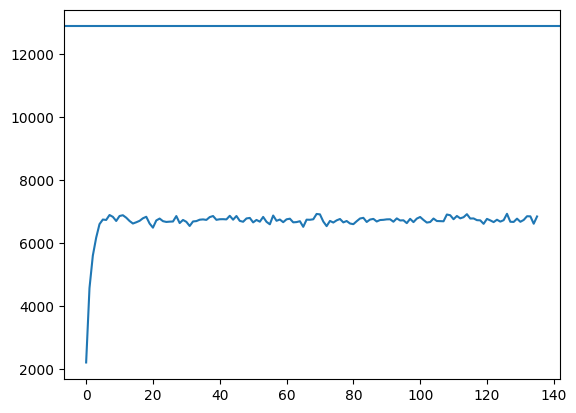

In [23]:
L=14
plt.plot(np.stack(data_df.xs(0.05, level='p_m').xs(L,level='L')['observations']).mean(axis=0))
plt.axhline(np.pi/4 * 2**(L))

In [9]:
np.pi/4 * 2**(L*2)

210828714.13315654

In [25]:
L_list = np.arange(12,25,2)

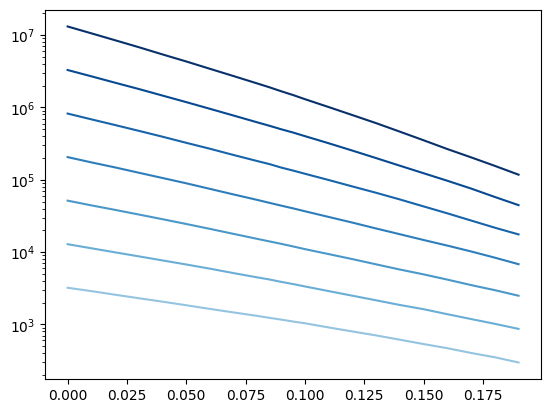

In [38]:
p_m_list = np.round(P_M_VALUES,3)
fig,ax=plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
for idx,L in enumerate(L_list):
    data = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for p_m in p_m_list]
    ax.plot(p_m_list, data, color=color_list[idx])
ax.set_yscale('log')
    

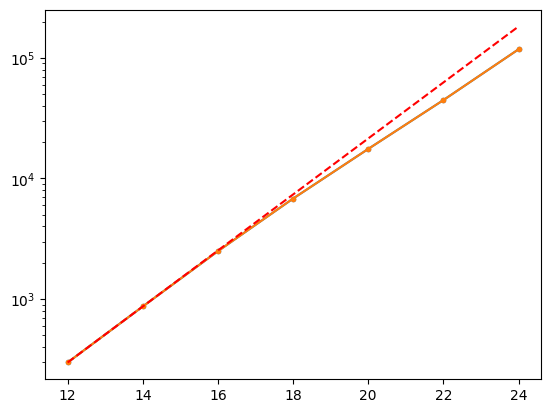

In [63]:
p_m = 0.19
fig, ax =plt.subplots()
x = L_list
y = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for L in L_list]
# y = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[-1:].mean() for L in L_list]
ax.plot(x, y,'.-')
ax.set_yscale('log')

# Here I want to use the first two points of "(x,y)", then fit linear in the linear-log scale, and plot it, using numpy,

# Take the first two points
x_fit = x[:2]
y_fit = y[:2]

# Fit a line in linear-log scale
log_y = np.log10(y_fit)
slope, intercept = np.polyfit(x_fit, log_y, 1)

# Create a function for the fitted line
def fitted_line(L):
    return 10**(intercept + slope * L)

# Plot the original data and the fitted line
ax.plot(x, y, '.-')
ax.plot(x, fitted_line(np.array(x)), 'r--')


In [ ]:
k

# p_f =1

In [68]:
import matplotlib.pyplot as plt

In [ ]:
L_list = [12, 14, 16, 18, 20,22,]

KeyError: 24

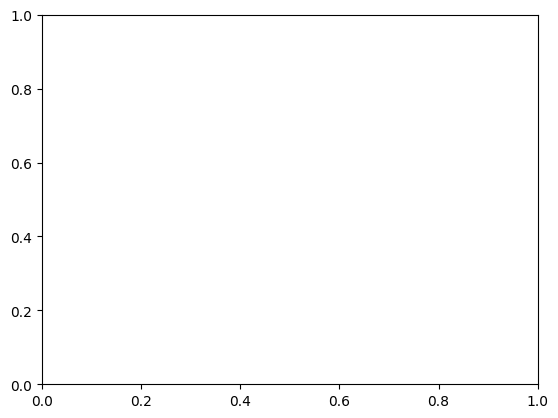

In [83]:
p_m = 0.04
fig, ax =plt.subplots()
x = L_list
y = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for L in L_list]
# y = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[-1:].mean() for L in L_list]
ax.plot(x, y,'.-')
ax.set_yscale('log')

# Here I want to use the first two points of "(x,y)", then fit linear in the linear-log scale, and plot it, using numpy,

# Take the first two points
x_fit = x[:2]
y_fit = y[:2]

# Fit a line in linear-log scale
log_y = np.log10(y_fit)
slope, intercept = np.polyfit(x_fit, log_y, 1)

# Create a function for the fitted line
def fitted_line(L):
    return 10**(intercept + slope * L)

# Plot the original data and the fitted line
ax.plot(x, y, '.-')
ax.plot(x, fitted_line(np.array(x)), 'r--')


In [ ]:
k


In [31]:
P_M_VALUES

array([0.   , 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.085, 0.09 , 0.095, 0.1  , 0.11 , 0.12 , 0.13 , 0.14 , 0.15 ,
       0.16 , 0.17 , 0.18 , 0.19 ])

Index([  0.0,  0.02,  0.04,  0.06,  0.07,  0.08, 0.085,  0.09, 0.095,   0.1,
        0.11,  0.12,  0.13,  0.14,  0.16,  0.18],
      dtype='float64', name='p_m')

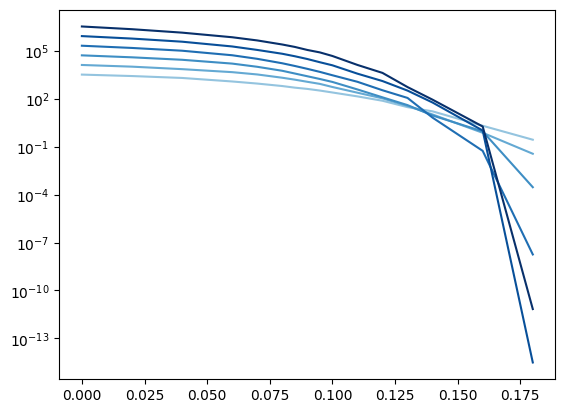

In [74]:
p_m_list = np.round(P_M_VALUES,3)
fig,ax=plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
p_m_list = data_df.index.get_level_values('p_m').unique()
for idx,L in enumerate(L_list):
    data = [np.stack(data_df.xs(p_m, level='p_m').xs(L,level='L')['observations']).mean(axis=0)[int(L**1.6):].mean() for p_m in p_m_list]
    ax.plot(p_m_list, data, color=color_list[idx])
ax.set_yscale('log')
    

In [ ]:
k